In [1]:
import numpy as np
from typing import Tuple, List
import cv2
import matplotlib.pyplot as plt

class COVIDOASegmentation:
    def __init__(self, population_size: int = 50, max_iter: int = 100, 
                 weights: Tuple[float, float, float] = (0.6, 0.3, 0.1)):
        """
        Initialize COVIDOA-based multilevel thresholding segmentation.
        
        Args:
            population_size: Number of solutions in population
            max_iter: Maximum number of iterations
            weights: Weights for hybrid fitness function (Otsu, Kapur, Tsallis)
        """
        self.population_size = population_size
        self.max_iter = max_iter
        self.w_otsu, self.w_kapur, self.w_tsallis = weights
        
    def compute_probability(self, histogram: np.ndarray) -> np.ndarray:
        """Compute probability distribution from histogram."""
        return histogram / np.sum(histogram)
    
    def otsu_fitness(self, prob: np.ndarray, threshold: int) -> float:
        """
        Calculate Otsu's between-class variance for bilevel thresholding.
        """
        w0 = np.sum(prob[:threshold])
        w1 = 1 - w0
        
        if w0 == 0 or w1 == 0:
            return 0
            
        mu0 = np.sum(np.arange(threshold) * prob[:threshold]) / w0
        mu1 = np.sum(np.arange(threshold, len(prob)) * prob[threshold:]) / w1
        
        return w0 * w1 * ((mu0 - mu1) ** 2)
    
    def kapur_fitness(self, prob: np.ndarray, threshold: int) -> float:
        """
        Calculate Kapur's entropy for bilevel thresholding.
        """
        if threshold == 0 or threshold == len(prob):
            return 0
            
        p1 = prob[:threshold]
        p2 = prob[threshold:]
        
        w0 = np.sum(p1)
        w1 = np.sum(p2)
        
        if w0 == 0 or w1 == 0:
            return 0
            
        h1 = -np.sum((p1/w0) * np.log2(p1/w0 + np.finfo(float).eps))
        h2 = -np.sum((p2/w1) * np.log2(p2/w1 + np.finfo(float).eps))
        
        return h1 + h2
    
    def tsallis_fitness(self, prob: np.ndarray, threshold: int, q: float = 0.8) -> float:
        """
        Calculate Tsallis entropy for bilevel thresholding.
        """
        if threshold == 0 or threshold == len(prob):
            return 0
            
        p1 = prob[:threshold]
        p2 = prob[threshold:]
        
        w0 = np.sum(p1)
        w1 = np.sum(p2)
        
        if w0 == 0 or w1 == 0:
            return 0
            
        p1_norm = p1 / w0
        p2_norm = p2 / w1
        
        s1 = (1 - np.sum(p1_norm ** q)) / (q - 1)
        s2 = (1 - np.sum(p2_norm ** q)) / (q - 1)
        
        return s1 + s2 + (1 - q) * s1 * s2
    
    def hybrid_fitness(self, prob: np.ndarray, threshold: int) -> float:
        """
        Calculate hybrid fitness function combining Otsu, Kapur and Tsallis methods.
        """
        otsu = self.otsu_fitness(prob, threshold)
        kapur = self.kapur_fitness(prob, threshold)
        tsallis = self.tsallis_fitness(prob, threshold)
        
        return (self.w_otsu * otsu + 
                self.w_kapur * kapur + 
                self.w_tsallis * tsallis)
    
    def virus_entry(self, lb: int, ub: int, dimension: int) -> np.ndarray:
        """Initialize random solution within bounds."""
        solution = np.zeros(dimension)
        
        # Calculate maximum value for first threshold to ensure space for others
        max_first = ub - (dimension - 1)
        solution[0] = np.random.randint(lb, max_first)
        
        # Generate remaining thresholds with proper spacing
        for i in range(1, dimension):
            min_val = solution[i-1] + 1
            max_val = ub - (dimension - i - 1)
            if min_val >= max_val:
                solution[i] = min_val
            else:
                solution[i] = np.random.randint(min_val, max_val)
        
        return solution
    
    def frameshifting(self, parent: np.ndarray, lb: int, ub: int) -> np.ndarray:
        """Apply frameshifting operation to generate new solution."""
        solution = parent.copy()
        shift = np.random.randint(1, 3)  # +1 or +2 frameshifting
        
        # Ensure first threshold has enough room for subsequent thresholds
        max_first = ub - (len(solution) - 1) * shift
        solution[0] = np.random.randint(lb, max_first)
        
        # Apply shifting while ensuring bounds
        for i in range(1, len(solution)):
            solution[i] = min(solution[i-1] + shift, ub - (len(solution) - i - 1))
            
        return solution
    
    def mutation(self, solution: np.ndarray, lb: int, ub: int, 
                mutation_rate: float = 0.1) -> np.ndarray:
        """
        Apply mutation to solution with proper bounds checking.
        
        Args:
            solution: Current solution vector
            lb: Lower bound
            ub: Upper bound
            mutation_rate: Probability of mutation for each element
            
        Returns:
            Mutated solution
        """
        mutated = solution.copy()
        for i in range(len(solution)):
            if np.random.random() < mutation_rate:
                if i == 0:
                    # First threshold: ensure valid range with next threshold
                    high = min(mutated[i+1], ub) if len(solution) > 1 else ub
                    if lb < high:
                        mutated[i] = np.random.randint(lb, high)
                elif i == len(solution) - 1:
                    # Last threshold: ensure valid range with previous threshold
                    low = max(mutated[i-1] + 1, lb)
                    if low < ub:
                        mutated[i] = np.random.randint(low, ub)
                else:
                    # Middle thresholds: ensure valid range between adjacent thresholds
                    low = max(mutated[i-1] + 1, lb)
                    high = min(mutated[i+1], ub)
                    if low < high:
                        mutated[i] = np.random.randint(low, high)
        
        # Ensure thresholds are strictly increasing
        for i in range(1, len(mutated)):
            if mutated[i] <= mutated[i-1]:
                mutated[i] = min(mutated[i-1] + 1, ub - (len(mutated) - i - 1))
        
        return mutated
    
    def segment_image(self, image: np.ndarray, num_thresholds: int) -> Tuple[np.ndarray, List[int]]:
        """
        Perform multilevel thresholding segmentation on the input image.
        
        Args:
            image: Input grayscale image
            num_thresholds: Number of thresholds to find
            
        Returns:
            Tuple of segmented image and optimal thresholds
        """
        histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).ravel()
        prob = self.compute_probability(histogram)
        
        # Initialize population
        population = np.array([self.virus_entry(0, 255, num_thresholds) 
                             for _ in range(self.population_size)])
        best_solution = None
        best_fitness = float('-inf')
        
        # Main COVIDOA loop
        for _ in range(self.max_iter):
            # Evaluate current population
            for solution in population:
                fitness = sum(self.hybrid_fitness(prob, int(t)) for t in solution)
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_solution = solution.copy()
            
            # Generate new solutions
            new_population = []
            for _ in range(self.population_size):
                # Frameshifting
                offspring = self.frameshifting(best_solution, 0, 255)
                # Mutation
                offspring = self.mutation(offspring, 0, 255)
                new_population.append(offspring)
            
            population = np.array(new_population)
        
        # Apply thresholding
        thresholds = sorted([int(t) for t in best_solution])
        segmented = np.zeros_like(image)
        
        for i in range(len(thresholds) + 1):
            if i == 0:
                mask = image <= thresholds[i]
                segmented[mask] = 0
            elif i == len(thresholds):
                mask = image > thresholds[i-1]
                segmented[mask] = 255
            else:
                mask = (image > thresholds[i-1]) & (image <= thresholds[i])
                segmented[mask] = int(255 * (i / len(thresholds)))
        
        return segmented, thresholds

def process_color_image(image_path: str, num_thresholds: int = 2) -> np.ndarray:
    """
    Process a color image using multilevel thresholding on each channel.
    
    Args:
        image_path: Path to input image
        num_thresholds: Number of thresholds per channel
        
    Returns:
        Segmented color image
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read image")
    
    # Initialize segmentation
    segmenter = COVIDOASegmentation()
    result = np.zeros_like(image)
    
    # Process each channel
    for channel in range(3):
        segmented, _ = segmenter.segment_image(image[:,:,channel], num_thresholds)
        result[:,:,channel] = segmented
        
    return result

In [2]:
def plot_comparison(image_path: str, num_thresholds: int = 2, figsize: tuple = (12, 5)):
    """
    Plot original and segmented images side by side.
    
    Args:
        image_path: Path to the input image
        num_thresholds: Number of thresholds for segmentation
        figsize: Size of the figure (width, height)
    """
    # Read the original image
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError("Could not read image")
    
    # Convert BGR to RGB for proper display
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Perform segmentation
    segmenter = COVIDOASegmentation()
    segmented = process_color_image(image_path, num_thresholds)
    segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot original image
    ax1.imshow(original_rgb)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Plot segmented image
    ax2.imshow(segmented_rgb)
    ax2.set_title(f'Segmented Image\n({num_thresholds} thresholds)')
    ax2.axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

def plot_detailed_comparison(image_path: str, num_thresholds: int = 2, figsize: tuple = (15, 12)):
    """
    Plot detailed comparison including original, segmented, and individual RGB channels.
    
    Args:
        image_path: Path to the input image
        num_thresholds: Number of thresholds for segmentation
        figsize: Size of the figure (width, height)
    """
    # Read and process images
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError("Could not read image")
    
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    segmented = process_color_image(image_path, num_thresholds)
    segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB)
    
    # Create figure with subplots (3 rows, 3 columns)
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    # Row 1: Original image and its channels
    axes[0, 0].imshow(original_rgb)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    channel_names = ['Red', 'Green', 'Blue']
    for i in range(2):  # Only plotting Red and Green channels in first row
        axes[0, i+1].imshow(original_rgb[:,:,i], cmap='gray')
        axes[0, i+1].set_title(f'Original {channel_names[i]} Channel')
        axes[0, i+1].axis('off')
    
    # Row 2: Segmented image and remaining channel
    axes[1, 0].imshow(segmented_rgb)
    axes[1, 0].set_title(f'Segmented Image\n({num_thresholds} thresholds)')
    axes[1, 0].axis('off')
    
    # Blue channel
    axes[1, 1].imshow(original_rgb[:,:,2], cmap='gray')
    axes[1, 1].set_title(f'Original {channel_names[2]} Channel')
    axes[1, 1].axis('off')
    
    # Histogram
    axes[1, 2].hist(original_rgb.ravel(), bins=256, color='gray', alpha=0.7)
    axes[1, 2].set_title('Histogram of Original Image')
    axes[1, 2].set_xlabel('Pixel Intensity')
    axes[1, 2].set_ylabel('Frequency')
    
    # Row 3: Segmented channels
    for i in range(3):
        axes[2, i].imshow(segmented_rgb[:,:,i], cmap='gray')
        axes[2, i].set_title(f'Segmented {channel_names[i]} Channel')
        axes[2, i].axis('off')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

def save_results(image_path: str, output_dir: str, num_thresholds: int = 2):
    """
    Save original and segmented images to files.
    
    Args:
        image_path: Path to the input image
        output_dir: Directory to save results
        num_thresholds: Number of thresholds for segmentation
    """
    import os
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Read and process images
    original = cv2.imread(image_path)
    if original is None:
        raise ValueError("Could not read image")
    
    segmented = process_color_image(image_path, num_thresholds)
    
    # Get base filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Save results
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_original.png"), original)
    cv2.imwrite(os.path.join(output_dir, f"{base_name}_segmented.png"), segmented)
    
    # Create and save comparison plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
    plt.title(f'Segmented Image ({num_thresholds} thresholds)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{base_name}_comparison.png"))
    plt.close()

In [3]:
class LesionSegmentation:
    def __init__(self, covidoa_segmenter: COVIDOASegmentation):
        """
        Initialize lesion segmentation with COVIDOA segmenter.
        
        Args:
            covidoa_segmenter: Instance of COVIDOASegmentation class
        """
        self.segmenter = covidoa_segmenter
        
    def create_ground_truth(self, segmented_image: np.ndarray) -> np.ndarray:
        """
        Create binary ground truth mask from segmented image.
        
        Args:
            segmented_image: Segmented image from COVIDOA
            
        Returns:
            Binary mask where lesion is white (255) and background is black (0)
        """
        # Convert to grayscale if color
        if len(segmented_image.shape) == 3:
            gray = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2GRAY)
        else:
            gray = segmented_image
            
        # Threshold to create binary mask
        _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
        mask = cv2.bitwise_not(mask)
        
        # Clean up mask using morphological operations
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        
        return mask

    def apply_mask_to_original(self, original: np.ndarray, mask: np.ndarray) -> np.ndarray:
        """
        Apply ground truth mask to original image to create segmented result.
        
        Args:
            original: Original input image
            mask: Binary ground truth mask
            
        Returns:
            Segmented result showing lesion from original image
        """
        # Create result image with black background
        result = np.zeros_like(original)
        
        # Copy original image pixels where mask is white
        result[mask == 255] = original[mask == 255]
        
        return result

    def process_image(self, image_path: str, num_thresholds: int = 2) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Process image to create ground truth and segmented result.
        
        Args:
            image_path: Path to input image
            num_thresholds: Number of thresholds for segmentation
            
        Returns:
            Tuple of (original image, ground truth mask, segmented result)
        """
        # Read original image
        original = cv2.imread(image_path)
        if original is None:
            raise ValueError("Could not read image")
            
        # Get initial segmentation
        segmented = self.segmenter.segment_image(cv2.cvtColor(original, cv2.COLOR_BGR2GRAY), 
                                               num_thresholds)[0]
        
        # Create ground truth mask
        ground_truth = self.create_ground_truth(segmented)
        
        # Apply mask to original
        result = self.apply_mask_to_original(original, ground_truth)
        
        return original, ground_truth, result

    def visualize_results(self, original: np.ndarray, ground_truth: np.ndarray, 
                         segmented: np.ndarray, save_path: str = None) -> None:
        """
        Visualize or save the segmentation results.
        
        Args:
            original: Original input image
            ground_truth: Ground truth mask
            segmented: Segmented result
            save_path: Optional path to save visualization
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(ground_truth, cmap='gray')
        axes[1].set_title('Ground Truth Mask')
        axes[1].axis('off')
        
        axes[2].imshow(cv2.cvtColor(segmented, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Segmented Result')
        axes[2].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        else:
            plt.show()

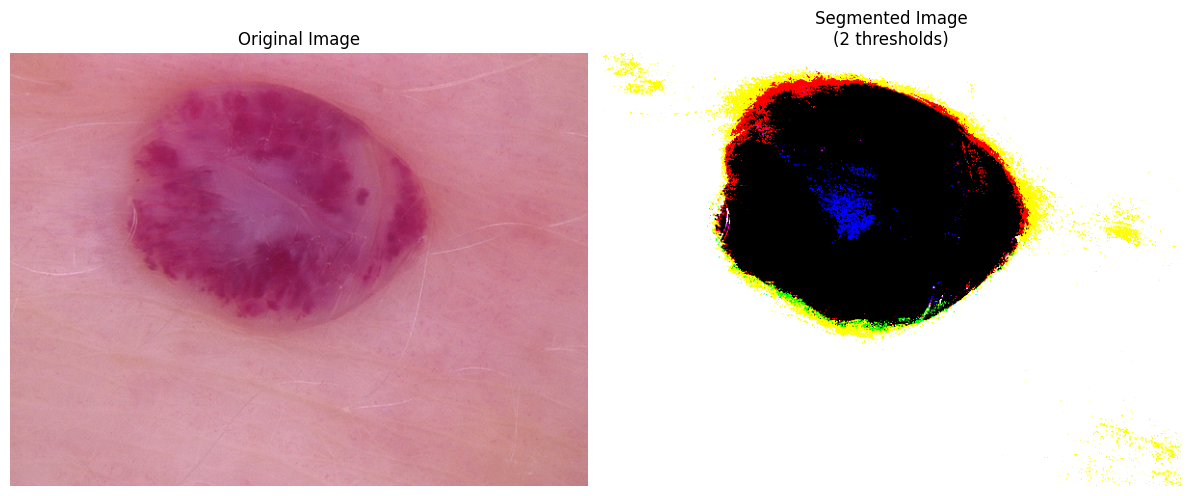

In [7]:
# Basic comparison
image_path = "/kaggle/input/multiclassskincancer/train_directory/vasc/ISIC_0024370.jpg"
plot_comparison(image_path, num_thresholds=2)

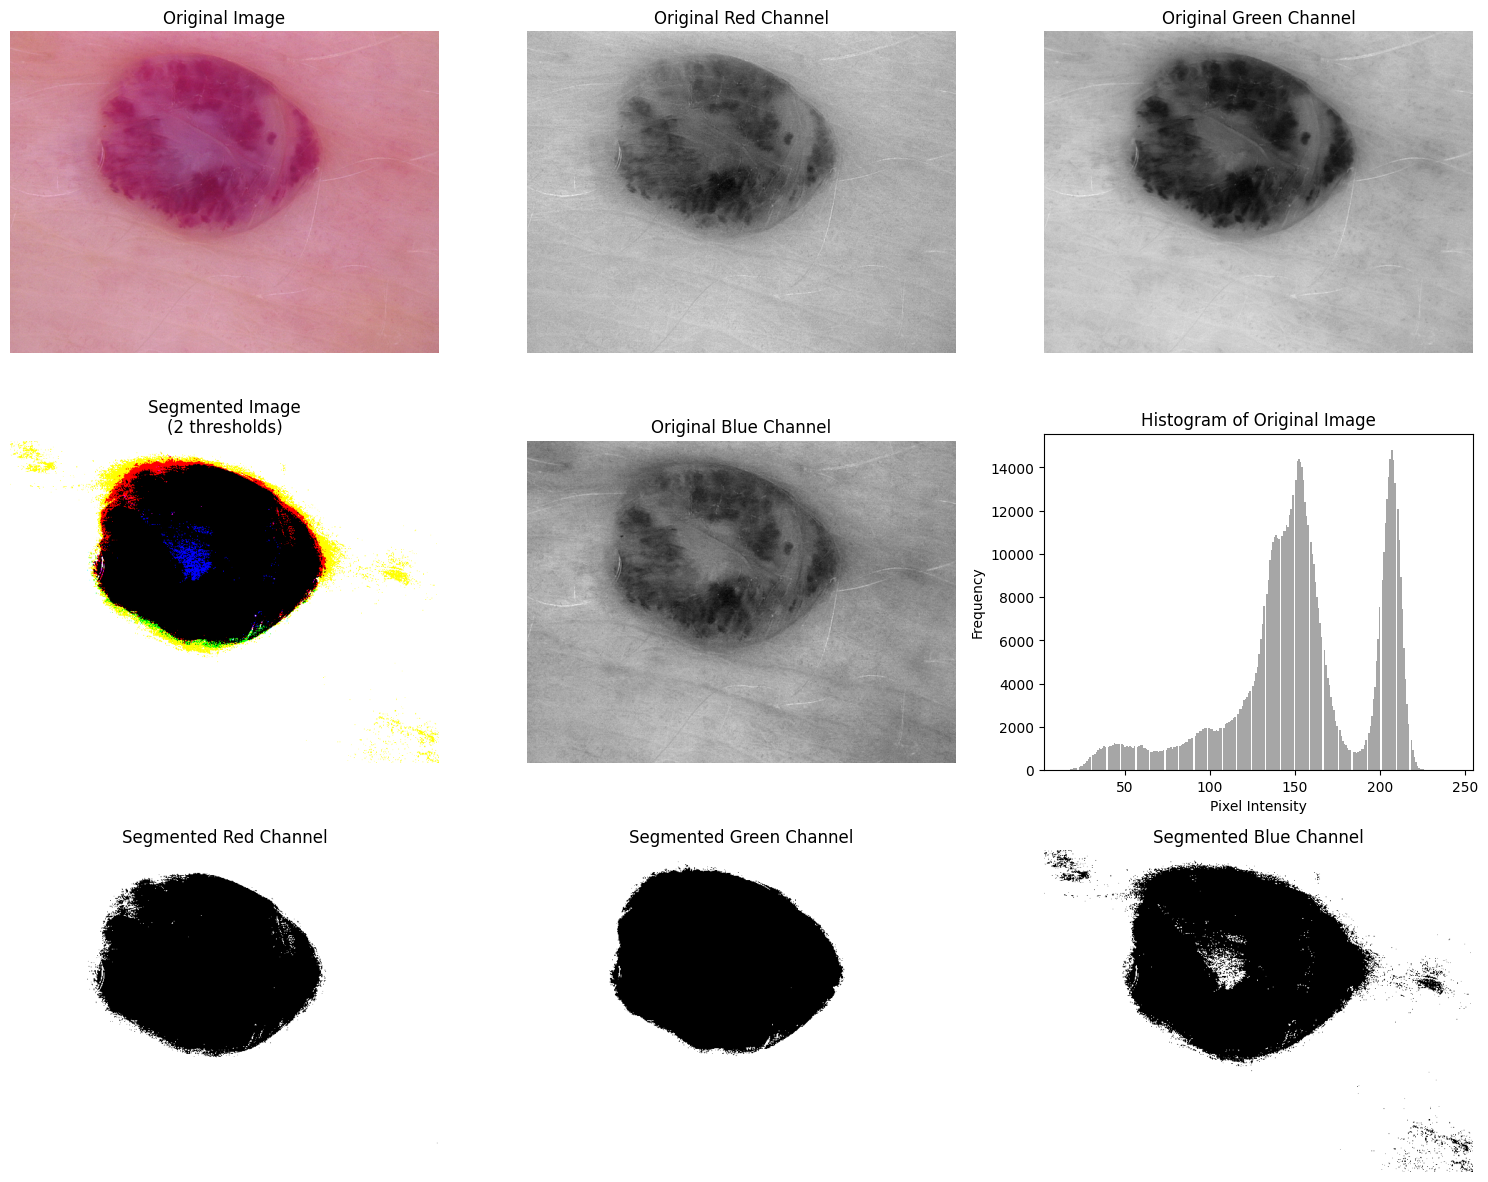

In [8]:
# Detailed analysis
plot_detailed_comparison(image_path, num_thresholds=2)

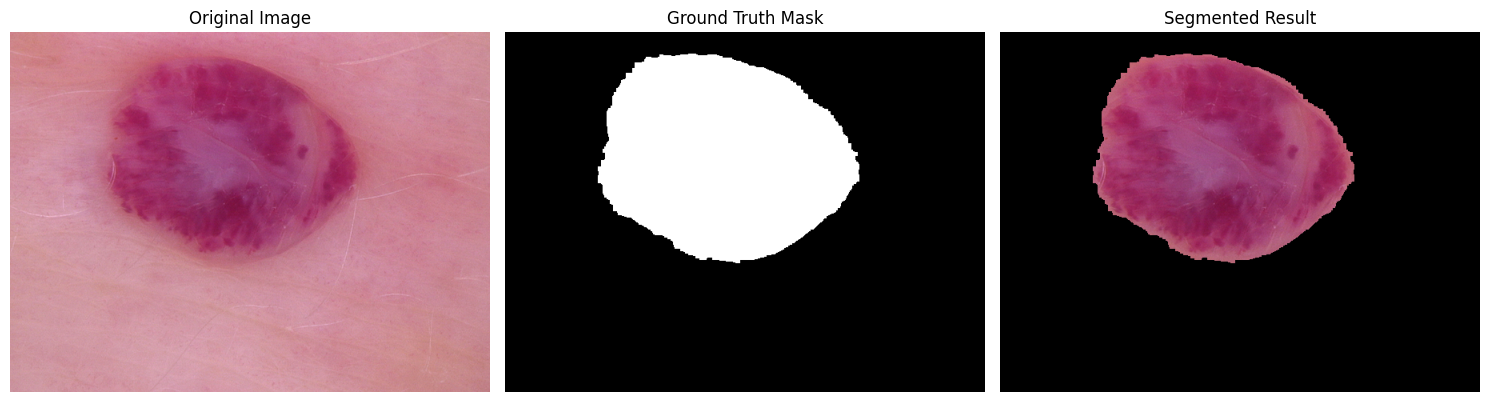

In [9]:
# Initialize the segmenters
covidoa = COVIDOASegmentation()
lesion_segmenter = LesionSegmentation(covidoa)

# Process an image
image_path = "/kaggle/input/multiclassskincancer/train_directory/vasc/ISIC_0024370.jpg"
original, ground_truth, segmented = lesion_segmenter.process_image(image_path)

# Visualize results
lesion_segmenter.visualize_results(original, ground_truth, segmented)